# 7. Temporal Difference Learning Introduction
We are now going to look at a third method for solving MDPs, _**Temporal Difference Learning**_. TD is one of the most important ideas in RL, and we will see how it combines ideas from the first two techniques, Dynamic Programming and Monte Carlo. 

Recall that one of the disadvantages of DP was that it requires a full model of environment, and never learns from experience. On the other hand, we saw that MC does learn from experience, and we will shortly see that TD learns from experience as well. 

With the Monte Carlo method, we saw that we could only update the value function after completing an episode. On the other hand, DP uses bootstrapping and was able to improve its estimates based on existing estimates. We will see that TD learning also uses bootstrapping, and furthermore is fully online, so we don't need to wait for an episode to finish before we start updating our value estimates. 

In this section we will take our standard approach:
> 1. First we will look at the prediction problem, aka finding the value function given a policy.
2. Second we will look at the control problem. We will look at 2 different ways of approaching the control problem: **SARSA** and **Q-Learning**.  

---

# 2. Prediction Problem - `TD(0)`
We are now going to look at how to apply TD to the prediction problem, aka finding the value function. The reason that there is a 0 in the name is because there are other TD learning methods such as `TD(1)` and `TD(`${\lambda}$`)`, but they are outside the scope of this course. They are similar, but not necessary to understand _Q-learning_ and _Approximation methods_, which is what we eventually want to get to.

## 2.1 Monte Carlo Disadvantage
One big disadvantage of Monte Carlo was that we needed to wait until the episode is finished before we can calculate the returns, since the return depends on all future rewards. Also, recall that the MC method is to average the returns, and that earlier in the course we looked at different ways of calculating averages. 

## 2.2 `TD(0)`
In particular, we can look at the method that does not require us to store all of the returns: _the moving average_. 

$$Y_t = (1 - \alpha)Y_{t-1} + \alpha X_t$$
$$Y_t = Y_{t-1} - \alpha Y_{t-1} + \alpha X_t$$
$$Y_t = Y_{t-1} + \alpha ( X_t - Y_{t-1})$$

Recall that $\alpha$ can be constant or decay with time. So, if we use this formula it would be an alternative way of caculating the average reward for a state. 

$$V(S_t) \leftarrow V(S_t) + \alpha \big[G(t) - V(S_t)\big]$$

Annotated:

<img src="images/moving-average-TD.png">

In this case we have chosen to not multiply the previous value by $1 - \alpha$, and we have chosen to have $\alpha$ be constant (instead of slowly get smaller over time).

Now recall the definition of $V$; it is the expected value of the return, given a state:

$$V(s) = E \big[G(t) \mid S_t = s\big]$$

But, remember that we can also define it recursively:

$$V(s) = E \big[R(t+1) + \lambda V(S_{t+1}) \mid S_t =s\big]$$

So, it is reasonable to ask if we can just replace the return in the update equation with this recursive definition of $V$! What we get from this, is the `TD(0)` method:

$$V(S_t) = V(S_t) + \alpha \big[R(t+1) + \lambda V(S_{t+1}) - V(S_t)\big]$$

<span style="color:#0000cc">$$\text{TD(0)} \rightarrow V(s) = V(s) + \alpha \big[r + \lambda V(s') - V(s)\big]$$</span>

We can also see how this is fully online! We are not calculating $G$, the full return. Instead, we are just using another $V$ estimate, in particular the $V$ for the next state. What this also tells us is that we cannot update $V(s)$ until we know $V(s')$. So, rather than waiting for the entire episode to finish, we just need to wait until we reach the next state to update the value for the current state. 

## 2.3 Sources of Randomness
It is helpful to examine how these estimates work, and what the sources of randomness are. 

> * With MC, the randomness came from the fact that each episode could play out in a different way. So, the return for a state would be different if all the later state transitions had some randomness. 
* With **`TD(0)`** we have yet another source of randomness. In particular, we don't even know the return, so instead we use $r + \gamma V(s')$ to estimate the return $G$. 

## 2.4 Summary
We just looked at why `TD(0)` is advantageous in comparison to MC/DP. 

> * Unlike DP, we do not require a full model of the environment, we learn from experience, and only update V for states we visit.
* Unlike MC, we don't need to wait for an episode to finish before we can start learning. This is advantageous in situations where we have very long episodes. We can improve our performance during the episode itself, rather than having to wait until the next episode.
* It can even be used for continuous tasks, in which there are no episodes at all. 

---

# 3. `TD(0)` in Code

In [1]:
import numpy as np
from common import standard_grid, negative_grid, print_policy, print_values

SMALL_ENOUGH = 10e-4
GAMMA = 0.9
ALPHA = 0.1 # Learning Rate
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

# NOTE: This is only policy evaluation, not optimization

def random_action (a, eps=0.1):
  """Adding randomness to ensure that all states are visited. We will use epsilon-soft 
  to ensure that all states are visited. What happens if you don't do this? i.e. eps = 0"""
  p = np.random.random()
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

def play_game(grid, policy):
  """Much simpler than MC version, because we don't need to calculate any returns. All
  we need to do is return a list of states and rewards."""
  s = (2, 0)
  grid.set_state(s)
  states_and_rewards = [(s, 0)] # list of tuples of (state, reward)
  while not grid.game_over():
    a = policy[s]
    a = random_action(a)
    r = grid.move(a)
    s = grid.current_state()
    states_and_rewards.append((s, r))
  return states_and_rewards

if __name__ == '__main__':
  # Use standard grid so that we can compare to iterative policy evaluation
  grid = standard_grid()
  
  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)
  
  # state -> action
  policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'R',
    (2, 1): 'R',
    (2, 2): 'R',
    (2, 3): 'U',
  }
  
  # Initialize V(s) and returns to 0. This occurs outside of for loop. The entire purpose
  # of the for loop is to converge onto V(s)! Remember, V(s) is a function, but since 
  # the number of states are enumerable, relatively small, and discrete, we can find 
  # the approximate value for each state. We don't need to solve for a continuous equation!
  states = grid.all_states()
  V = {v: 0 for v in states}
  
  # Repeat until convergence
  for it in range(1000):
    
    # Generate an episode using pi
    states_and_rewards = play_game(grid, policy)
    
    # the first (s, r) tuple is the state we start in and 0
    # (since we don't get a reward) for simply starting the game
    # the last (s, r) tuple is the terminal state and the final reward
    # the value for the terminal state is by definition 0, so we don't
    # care about updating it.
    # Once we have our states and rewards, we loop through them and do the TD(0) update
    # which is the equation from the theory we discussed. Notice that here we have 
    # generated a full episode and then are making our V(s) updates. We could have done 
    # them inline, but this allows for them to be cleaner and easier to follow. 
    
    # This is where our update equation is implemented
    for t in range(len(states_and_rewards) - 1):
      s, _ = states_and_rewards[t]
      s2, r = states_and_rewards[t + 1]
      
      # We will update V(s) AS we experience the episode
      update = V[s] + ALPHA * (r + GAMMA * V[s2] - V[s])
      V[s] = update
      
  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
values:
---------------------------
 0.76| 0.85| 0.95| 0.00|
---------------------------
 0.69| 0.00|-0.86| 0.00|
---------------------------
 0.57|-0.48|-0.70|-0.95|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  R  |  R  |  U  |


---

# 3. SARSA 
We are now going to look at how to apply the `TD(0)` algorithm to the control problem. We are going to apply `TD(0)` to _policy iteration_. In particular, we are going to use the value iteration method, where we continually update $Q$ based on itself. We are going to do it in place, and any actions we take are always greedy with respect to our current estimate of $Q$. So, we will be skipping the part where we do a full policy evaluation, and just immediately going to the more efficient form. 

Recall from the Monte Carlo section, that the reason we want to use $Q$ is because it allows us to choose an action based on the argmax of $Q$. We are not able to do this with $V$ because it is only indexed by the state. Since $Q$ has the same recursive form, we can apply the same update equation as before:

$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \Big[R(t+1) + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)\Big]$$

$$Q(s, a) \leftarrow Q(s, a) + \alpha \Big[r + \gamma Q(s', a') - Q(s,a)\Big]$$

Notice that we have the same limitation as we did with MC; since $Q$ is indexed by both state and action, we need many more iterations to gather enough data for convergence. Because the update depends on the 5-tuple (s,a,r,s',a') this method is called _**SARSA**_.  
## 3.1 What Policy to use?
Since SARSA requires us to know $Q(s,a)$ for all the possible actions $a$ in state $s$, so that we can accurately chose the argmax, we have the same problem as we did with MC. Recall, the problem was that if you follow a deterministic policy, you will only ever do $\frac{1}{|A|}$ of the possible actions, which will leave most of $Q$ undefined. To fix this we either have to use exploring starts, or a policy that allows for exploration, like epsilon-greedy. Since we know that exploring starts is not realistic, we are going to use epsilon greedy. 

## 3.2 Pseudocode

---

```
Q(s,a) = artibtrary, Q(terminal, a) = 0 
for t=1..N:
  # Start a game
  s = start_state, a = epsilon_greedy_from(Q(s))
  while not game_over:
    s', r = do_action(a)
    a' = epsilon_greedy_from(Q(s'))
    Q(s,a) = Q(s,a) + alpha*[r + gamma*Q(s', a') - Q(s,a)]
    s = s', a = a'
```

---

We can see that our pseudocode functions as follows:
> * We initialize $Q$ arbitrarily, and set it to 0 for any terminal state.
* We then enter an infinite loop
* Inside the loop we start a game 
* We get the first state and select the first action based on epsilon greedy and the current $Q$. This is our tuple (s, a)
* Inside this loop we start another loop that ends when the game is over 
* We do the action $a$ to get to the state $s'$ and get the reward $r$ 
* We then choose the next state based on epsilon greedy and the current $Q$. We'll call this $a'$
* Then we do our update for $Q(s,a)$, which depends on $Q(s,a)$ itself, $r$, and $Q(s',a')$
* Next, we update s to be s', and we update a to be a'

An interesting fact about SARSA is that a convergence proof has never been published. However, it has been stated that SARSA will converge if the policy converges to a greedy policy. One way to achieve this is to let $\epsilon = \frac{1}{t}$, where $t$ represents time. 

## 3.3 Learning Rate
Recall that we can also have a decaying learning rate. There is a problem with using a $\alpha = \frac{1}{t}$ decay though. Only one state action pair will be updated in $Q$. Therefore, the learning rate will decay for values of $Q$ that have never been updated before. You could try to remedy this by only decaying the learning rate once per episode, but you still have the same problem. Only a subset of the full set of states are going to be visited in the episode, and only one of the possible actions per state are going to be taken. So, even if you decay the learning rate once per episode, you will still be decaying the learning rate for parts of $Q$ that have never been updated before. 

To solve this, we take inspiration from deep learning; in particular the AdaGrad and RMSprop algorithms, which are both adaptive learning rates. Recall, what makes these unique is that the effective learning rates decrease more when past gradients have been large. In other words, the more something has changed in the past, the more we will decrease the learning rate in the future. 

Our version will be simpler than these techniques, but the idea is the same. We are going to keep a count of how many times we have seen a state action pair (s, a). We will set $\alpha$ to be the original $\alpha$ divided by this count:

$$\alpha(s,a) = \frac{\alpha_0}{count(s,a)}$$

Equivalently:

$$\alpha(s,a) = \frac{\alpha_0}{k + m*count(s,a)}$$

Every state action pair now has its own alpha, and so each will have its own individually decaying learning rate. 

---

# 4. SARSA in Code

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from common import standard_grid, negative_grid, print_policy, print_values, max_dict

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|
it: 0
it: 2000
it: 4000
it: 6000
it: 8000


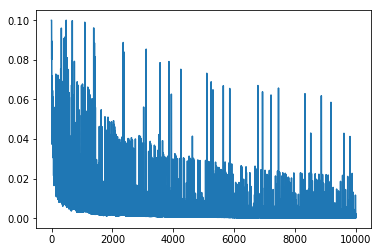

update counts:
---------------------------
 0.19| 0.18| 0.18| 0.00|
---------------------------
 0.19| 0.00| 0.04| 0.00|
---------------------------
 0.18| 0.02| 0.02| 0.00|
values:
---------------------------
 0.49| 0.72| 1.00| 0.00|
---------------------------
 0.29| 0.00| 0.71| 0.00|
---------------------------
 0.11| 0.14| 0.38| 0.15|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |


In [3]:
GAMMA = 0.9
ALPHA = 0.1 # Effective Alpha will be derived from this initial alpha
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

# Notice this in this script there is no play_game function. That is because with SARSA
# playing the games and performing the updates cannot be separate. We have to do the 
# updates while playing the game. So, TD methods are fully online!

if __name__ == '__main__':
  # NOTE: if we use the standard grid, there's a good chance we will end up with
  # suboptimal policies
  # e.g.
  # ---------------------------
  #   R  |   R  |   R  |      |
  # ---------------------------
  #   R* |      |   U  |      |
  # ---------------------------
  #   U  |   R  |   U  |   L  |
  # since going R at (1,0) (shown with a *) incurs no cost, it's OK to keep doing that.
  # we'll either end up staying in the same spot, or back to the start (2,0), at which
  # point we whould then just go back up, or at (0,0), at which point we can continue
  # on right.
  # instead, let's penalize each movement so the agent will find a shorter route.
  grid = negative_grid(step_cost=-0.1)
  
  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)
  
  # Initialize Q(s,a)
  Q = {
    state: {
      a: 0
      for a in ALL_POSSIBLE_ACTIONS
    }
    for state in states
  }
  
  # Create 2 update counts dictionaries. update_counts is to see what proportion of time
  # we spend in each state. update_counts_sa is for the adaptive learning rate.
  update_counts = {}
  update_counts_sa = {}
  for s in states:
    update_counts_sa[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      update_counts_sa[s][a] = 1.0
      
  # Repeat until convergence
  t = 1.0 # Using t for epsilon greedy. Only increases every 100 steps, by small amount. 
  deltas = []
  for it in range(10000):
    if it % 100 == 0:
      t += 1e-2
    if it % 2000 == 0:
      print("it:", it)
    
    # Instead of 'generating' an epsiode, we will PLAY an episode within this loop
    s = (2, 0) # start state
    grid.set_state(s)
    
    # the first (s, r) tuple is the state we start in and 0 (since we don't get a 
    # reward) for simply starting the game. The last (s, r) tuple is the terminal 
    # state and the final reward the value for the terminal state is by definition 0, 
    # so we don't care about updating it.
    a = max_dict(Q[s])[0]
    a = random_action(a, eps=0.5/t)
    biggest_change = 0
    
    # Enter the game loop
    while not grid.game_over():
      # Do action to find reward and next state 
      r = grid.move(a)
      s2 = grid.current_state()
      
      # Find next action based on epsilon greedy. We need the next action as well since 
      # Q(s,a) depends on Q(s',a'). If s2 not in policy then its a terminal state, where
      # all Q are 0
      a2 = max_dict(Q[s2])[0]
      a2 = random_action(a2, eps=0.5/t) # eps not constant, instead decaying with time
      
      # Calculate alpha -> Initial alpha / Count
      alpha = ALPHA / update_counts_sa[s][a]
      update_counts_sa[s][a] += 0.005 # Update count, only by small amount
      old_qsa = Q[s][a] # Keeping track of deltas. Want to know how Q changes as we learn
      
      # Q update! 
      Q[s][a] = Q[s][a] + alpha*(r + GAMMA*Q[s2][a2] - Q[s][a])
      biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))
      
      # Update update_counts dictionary - want to know how often Q(s) has been updated
      update_counts[s] = update_counts.get(s,0) + 1 
      
      # Set s and a to new s and a (s' and a'). Next state becomes current state.
      s = s2
      a = a2
      
    deltas.append(biggest_change)
  
  plt.plot(deltas)
  plt.show()
   
  # Since we want to print the policy, we need to find it by taking the argmax of Q
  # determine the policy from Q*
  # find V* from Q*
  policy = {}
  V = {}
  for s in grid.actions.keys():
    a, max_q = max_dict(Q[s])
    policy[s] = a
    V[s] = max_q
    
  # what's the proportion of time we spend updating each part of Q?
  print("update counts:")
  total = np.sum(list(update_counts.values()))
  for k, v in update_counts.items():
    update_counts[k] = float(v) / total
  print_values(update_counts, grid)

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

---

# 5. Q-Learning
We are now going to discuss _**Q-Learning**_. This is different from the strategy that we have been taking so far. The main theme so far behind each of the control algorithms that we have studied so far has been generalized policy iteration. We always alternate between: 
> * Policy evaluation
* Policy improvement (choosing an action greedily based on the current value function estimate)

All of these control algorithms are referred to as _**on-policy**_ methods. That means that we are playing the game using the current best policy. What is unique about Q-learning is that it is an _**off-policy**_ method. This means that the actions you take can be completely random, and yet you still end up being able to calculate the optimal policy. 

## 5.1 Q-Learning Theory
So, how does Q-Learning actually work? Well, it actually looks a lot like SARSA. The idea is, instead of choosing $a'$ based on the argmax of $Q$, we instead update $Q$ based on the max over all actions. 

$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \Big[R(t+1) + \gamma max_{a'} Q(S_{t+1}, a') - Q(S_t, A_t)\Big]$$

$$Q(s, a) \leftarrow Q(s, a) + \alpha \Big[r + \gamma max_{a'} Q(s', a') - Q(s,a)\Big]$$


Now you think yourself: isn't that exactly the same thing? If we choose $a'$ as the argmax of $Q$, then the thing beside $\gamma$ will be $Q(s',a')$, which is maxed over $a'$. 

The difference is, that Q-Learning is _off-policy_. With Q-Learning, remember that it is an off policy method. So, $Q(s',a')$ might be the max over all $a'$, but this doesn't necessarily mean that $a'$ has to be our next action. That is the difference. We update $Q(s,a)$ using the max of $Q(s',a')$, even if we don't end up doing the action $a'$ in the next step. What this suggests is that it doesn't really matter what policy we follow; we can choose actions randomly and still get the same answer. In reality, if we do take purely random actions, your agent will act suboptimally very often and that will make your episodes last longer. 

## 5.2 Key Difference
So, the key difference to remember:

> It doesn't matter what policy we use to play the game. It is reasonable to ask then, under what circumstances is Q-Learning equivalent to SARSA? If the policy you use during Q-Learning is a greedy policy, meaning that you always choose the argmax over $Q$, then your $Q(s',a')$ will correspond to the next action you take. In that case, you will be doing SARSA, but also Q-Learning. 

---

# 6. Q-Learning in Code

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|
it: 0
it: 2000
it: 4000
it: 6000
it: 8000


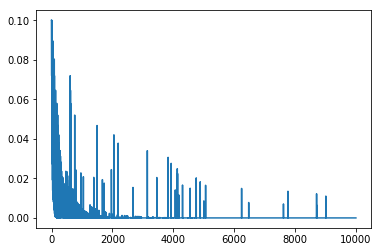

update counts:
---------------------------
 0.18| 0.18| 0.18| 0.00|
---------------------------
 0.19| 0.00| 0.04| 0.00|
---------------------------
 0.19| 0.02| 0.02| 0.00|
values:
---------------------------
 0.62| 0.80| 1.00| 0.00|
---------------------------
 0.46| 0.00| 0.80| 0.00|
---------------------------
 0.31| 0.46| 0.62| 0.46|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |


In [4]:
GAMMA = 0.9
ALPHA = 0.1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')


if __name__ == '__main__':
  # NOTE: if we use the standard grid, there's a good chance we will end up with
  # suboptimal policies
  # e.g.
  # ---------------------------
  #   R  |   R  |   R  |      |
  # ---------------------------
  #   R* |      |   U  |      |
  # ---------------------------
  #   U  |   R  |   U  |   L  |
  # since going R at (1,0) (shown with a *) incurs no cost, it's OK to keep doing that.
  # we'll either end up staying in the same spot, or back to the start (2,0), at which
  # point we whould then just go back up, or at (0,0), at which point we can continue
  # on right.
  # instead, let's penalize each movement so the agent will find a shorter route.
  #
  # grid = standard_grid()
  grid = negative_grid(step_cost=-0.1)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # no policy initialization, we will derive our policy from most recent Q

  # initialize Q(s,a)
  Q = {}
  states = grid.all_states()
  for s in states:
    Q[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      Q[s][a] = 0

  # let's also keep track of how many times Q[s] has been updated
  update_counts = {}
  update_counts_sa = {}
  for s in states:
    update_counts_sa[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      update_counts_sa[s][a] = 1.0

  # repeat until convergence
  t = 1.0
  deltas = []
  for it in range(10000):
    if it % 100 == 0:
      t += 1e-2
    if it % 2000 == 0:
      print("it:", it)

    # instead of 'generating' an epsiode, we will PLAY
    # an episode within this loop
    s = (2, 0) # start state
    grid.set_state(s)

    # the first (s, r) tuple is the state we start in and 0
    # (since we don't get a reward) for simply starting the game
    # the last (s, r) tuple is the terminal state and the final reward
    # the value for the terminal state is by definition 0, so we don't
    # care about updating it.
    a, _ = max_dict(Q[s])
    biggest_change = 0
    while not grid.game_over():
      a = random_action(a, eps=0.5/t) # epsilon-greedy
      # Can also perform uniform random action also works, but it is slower since you 
      # can bump into walls
      # a = np.random.choice(ALL_POSSIBLE_ACTIONS)
      r = grid.move(a)
      s2 = grid.current_state()
      
      # Adaptive learning rate
      alpha = ALPHA / update_counts_sa[s][a]
      update_counts_sa[s][a] += 0.005
      
      # We will update Q(s,a) AS WE EXPERIENCE the episode
      old_qsa = Q[s][a]
      # The difference between SARSA and Q-Learning is with Q-Learning we will use this 
      # max[a']{ Q(s',a') } in our update. Even if we do not end up taking this action
      # in our next step
      a2, max_q_s2a2 = max_dict(Q[s2])
      Q[s][a] = Q[s][a] + alpha * (r + GAMMA*max_q_s2a2 - Q[s][a])
      biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))
      
      # We want to know how often Q(s) has been updated too
      update_counts[s] = update_counts.get(s,0) + 1 
      
      # Next state becomes current state. Go back to top of while loop, and we can see
      # that we call `a = random_action(a, eps=0.5/t)`. This means that the `a` we 
      # chose here may not actually be used. `a2` was used to update our value function 
      # `Q`, but it may not be used in the next iteration. If we were following a purely
      # greedy policy then it would be used, and that is identical to SARSA. 
      s = s2
      a = a2
      
    deltas.append(biggest_change)
    
  plt.plot(deltas)
  plt.show()

  # determine the policy from Q*
  # find V* from Q*
  policy = {}
  V = {}
  for s in grid.actions.keys():
    a, max_q = max_dict(Q[s])
    policy[s] = a
    V[s] = max_q

  # what's the proportion of time we spend updating each part of Q?
  print("update counts:")
  total = np.sum(list(update_counts.values()))
  for k, v in update_counts.items():
    update_counts[k] = float(v) / total
  print_values(update_counts, grid)

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

---

# 7. Temporal Difference Learning Summary
Temporal Difference learning combines aspects from both Monte Carlo and Dynamic Programming. From Monte Carlo we incorporate ideas like learning from experience, meaning we actually play the game. We also learn how to generalize this idea of taking the sample mean from the returns (based on what we learned in the multi-armed bandit section). The problem of MC is that it is not fully online. 

We also incorporated ideas from Dynamic Programming such as bootstrapping, and using the recursive form of the value function to estimate the return. 

When we put these two together, we get `TD(0)`, where instead of taking the sample mean of returns, we take sample mean of estimated returns, based on the current reward, $r$, and the next state value, $V(s')$. 

For the **control** problem, we saw that again we needed to use the action value function instead of the state-value function, for the same reason as Monte Carlo Estimation. We derived the SARSA algorithm which combines ideas from value iteration, and `TD(0)`. We then discussed the difference between on-policy and off-policy algorithms and we determined in hindsight that all of the control solutions that we have seen have been _on-policy_, until now. At this point we learned about an _off-policy_ control solution, Q-Learning (which has gained traction recently, in part due to deep Q-Learning). 

One disadvantage of _all_ of these methods, is that they require us to estimate $Q$. As we learned early on, the state space can easily become infeasible to enumerate, and then on top of that for every state you need to enumerate all of the possible actions as well. So, in real world problems it is very possible that $Q$ does not even fit into memory! The method of measuring $Q(s,a)$ and storing it as a dictionary is called the _tabular method_. In fact, all of the methods we have learned about so far have been tabular methods. As you may imagine, tabular methods are only practical for small problems. In the next section, we will learn a new technique that helps us get around this problem, using _function approximation_. This will allow us to compress the amount of space that we need to represent $Q$. 